# Predicting Titanic Passenger Survival 

## Introduction
The Titanic sank off the coast of the North Atlantic after sideswiping an iceberg on April 15, 1912. This report will analyse Titanic passenger data and compare machine learning algorithms that predict whether a passenger will survive.
## Modules
These modules will allow us to visualize and apply learning algorithms in Python.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import decimal
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from statistics import mean
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

## Transformers and Functions
These are custom transformers we will use to preprocess the passenger data.

In [2]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # list of column to encode
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        output = X.copy()        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)        
        return output
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def cnf_matrix_LR(dat, test_ratio):
    cnf_matrix = [[0,0],[0,0]]
    for i in range(0, 200):
        dat = dat.sample(frac=1)
        train_set, test_set = split_train_test(dat, test_ratio)

        train_labels = train_set[0]
        test_labels = test_set[0]
        train_set.drop(train_set.columns[0], axis = 1) 
        test_set.drop(test_set.columns[0], axis = 1)

        log_reg = LogisticRegression()
        log_reg.fit(train_set, train_labels)

        predictions = log_reg.predict(test_set)
        cnf_matrix += confusion_matrix(test_labels, predictions)
        decimal.getcontext().rounding = decimal.ROUND_DOWN
    cm = cnf_matrix/200
    cm_df = pd.DataFrame(cm,
                     index = ['Died','Survived'], 
                     columns = ['Died','Survived'])

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True)
    plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(100*(cm[0,0]+cm[1,1])/cm.sum()))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return plt

def cnf_matrix_NB(dat, test_ratio):
    cnf_matrix = [[0,0],[0,0]]
    for i in range(0, 200):
        dat = dat.sample(frac=1)
        train_set, test_set = split_train_test(dat, test_ratio)

        train_labels = train_set[0]
        test_labels = test_set[0]
        train_set.drop(train_set.columns[0], axis = 1) 
        test_set.drop(test_set.columns[0], axis = 1)

        naive_bayes = GaussianNB()
        naive_bayes.fit(train_set, train_labels)
        GaussianNB(priors=None)

        predictions = naive_bayes.predict(test_set)
        cnf_matrix += confusion_matrix(test_labels, predictions)
        decimal.getcontext().rounding = decimal.ROUND_DOWN
    cm = cnf_matrix/200
    cm_df = pd.DataFrame(cm,
                     index = ['Died','Survived'], 
                     columns = ['Died','Survived'])

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True)
    plt.title('Naive Bayes \nAccuracy:{0:.3f}'.format(100*(cm[0,0]+cm[1,1])/cm.sum()))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return plt

## Load Data
The data is in a CSV file named "train.csv".

In [3]:
dat_raw = pd.read_csv("/Users/josemijangos/Desktop/train.csv")

## Missing Values
Most missing values are in the cabin attribute. Age has some missing values too but age could possibly be a good predictor. We can easily impute the missing values for age but we should ignore the cabin attribute.

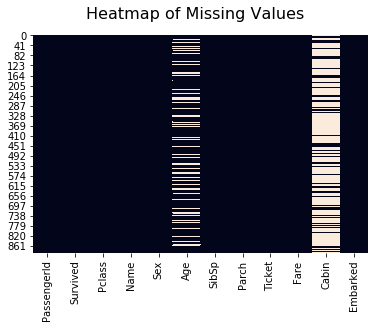

In [4]:
sns.heatmap(dat_raw.isnull(), cbar=False)
plt.suptitle('Heatmap of Missing Values', fontsize=16);

# Data Exploration 
In this exploration we will condition on various attributes to determine the best predictors for Survival. 
### Conditional Probability of Survival <br> Barplots

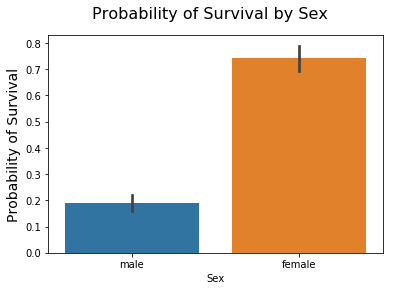

In [5]:
sns.barplot(x="Sex", y="Survived", data=dat_raw)
plt.suptitle('Probability of Survival by Sex', fontsize=16)
plt.ylabel('Probability of Survival', fontsize=14);

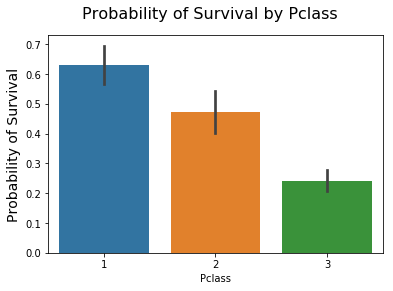

In [6]:
sns.barplot(x="Pclass", y="Survived", data=dat_raw)
plt.suptitle('Probability of Survival by Pclass', fontsize=16)
plt.ylabel('Probability of Survival', fontsize=14);

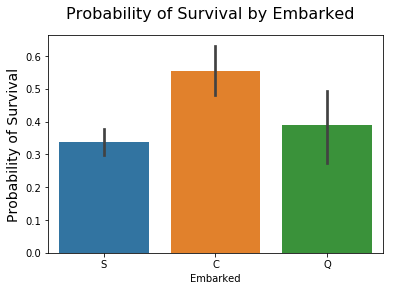

In [7]:
sns.barplot(x="Embarked", y="Survived", data=dat_raw)
plt.suptitle('Probability of Survival by Embarked', fontsize=16)
plt.ylabel('Probability of Survival', fontsize=14);

### Conditional Probability of Survival <br> Density Plots

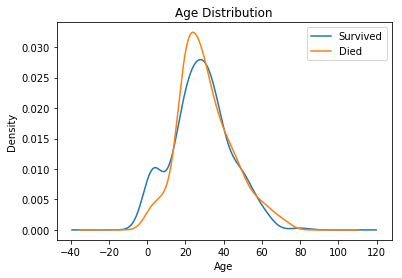

In [8]:
dat_raw.Age[dat_raw.Survived == 1].plot(kind='kde')    
dat_raw.Age[dat_raw.Survived == 0].plot(kind='kde')
plt.xlabel("Age")    
plt.title("Age Distribution")
plt.legend(('Survived', 'Died'),loc='best');

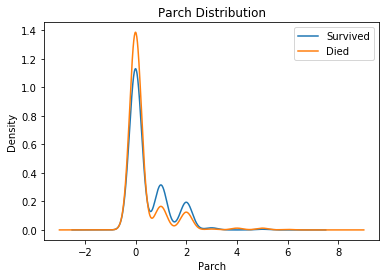

In [9]:
dat_raw.Parch[dat_raw.Survived == 1].plot(kind='kde')    
dat_raw.Parch[dat_raw.Survived == 0].plot(kind='kde')
plt.xlabel("Parch")    
plt.title("Parch Distribution")
plt.legend(('Survived', 'Died'),loc='best');

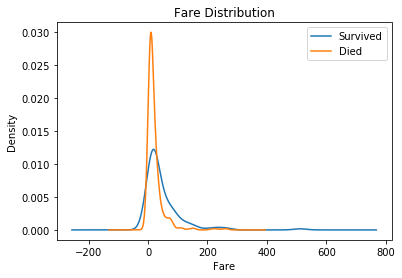

In [10]:
dat_raw.Fare[dat_raw.Survived == 1].plot(kind='kde')    
dat_raw.Fare[dat_raw.Survived == 0].plot(kind='kde')
plt.xlabel("Fare")    
plt.title("Fare Distribution")
plt.legend(('Survived', 'Died'),loc='best');

# Preprocess Data
## Selecting Numeric and Categorical Predictors
These attributes will be used to train our machine learning algorithms.
We are excluding features that we believe have nothing to do with a passengers chance of survival (i.e. PassengerID, Ticket). 
Also, our categorical feature pipeline requires categorical values to be strings.

In [11]:
num_features = ['Age','SibSp','Parch','Fare']
cat_features = ['Pclass','Sex','Embarked']

dat_raw[cat_features] = dat_raw[cat_features].astype(str)

## Preprocessing Pipelines
We preprocess numeric and categorical data in separate pipelines.

In [12]:
num_pipeline = Pipeline([
  ("selector", DataFrameSelector(num_features)),
  ("remove_nas", Imputer(strategy="median")),
  ("z-scaling", StandardScaler())
])

cat_pipeline = Pipeline([
  ('selector', DataFrameSelector(cat_features)),
  ('labeler', MultiColumnLabelEncoder()),
  ('encoder', OneHotEncoder(sparse = False)),
])

full_pipeline = FeatureUnion(transformer_list=[
  ("num_pipeline", num_pipeline),
  ("cat_pipeline", cat_pipeline),
])

## Applying Pipelines
After preprocessing, we have a normalized data frame with no missing values and labels.

In [13]:
dat = pd.DataFrame(np.concatenate((dat_raw[['Survived']], 
                      full_pipeline.fit_transform(dat_raw)), 1))

# Machine Learning Algorithms
Now that our data has been prepared we can train and test how well our machine learning algorithms predict survival. We will be using two classification algorithms, Logistic Regression and Naive Bayes.
## Logistic Regression
### Test 1
Training with 50% of data.<br> Testing with 50% of data.

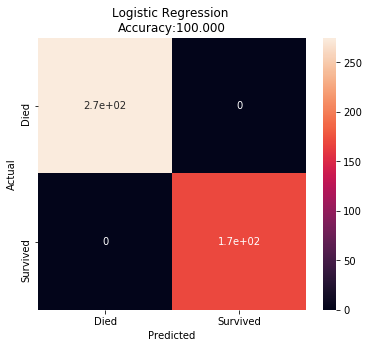

In [14]:
cnf_matrix_LR(dat, 0.50);

### Test 2
Training with 10% of data.<br> Testing with 90% of data.

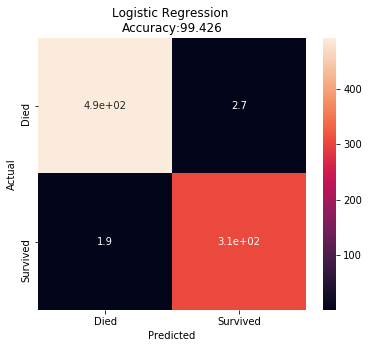

In [15]:
cnf_matrix_LR(dat, 0.90);

### Test 3
Training with 5% of data.<br> Testing with 95% of data.

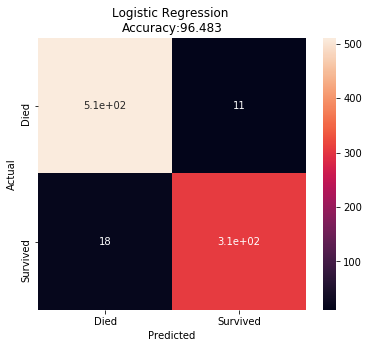

In [16]:
cnf_matrix_LR(dat, 0.95);

## Naive Bayes
### Test 1
Training with 50% of data.<br> Testing with 50% of data.

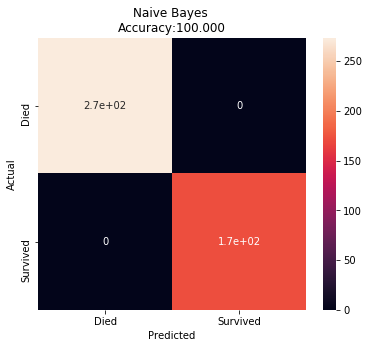

In [17]:
cnf_matrix_NB(dat, 0.50);

### Test 2
Training with 10% of data.<br> Testing with 90% of data.

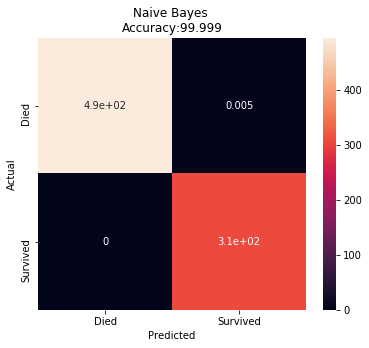

In [18]:
cnf_matrix_NB(dat, 0.90);

### Test 3
Training with 5% of data.<br> Testing with 95% of data.

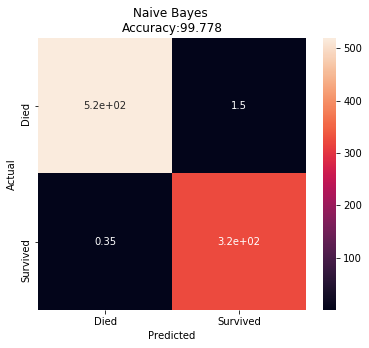

In [19]:
cnf_matrix_NB(dat, 0.95);

# Conclusions
Both Logistic Regression and Naive Bayes performed perfectly when there is plenty of training data. However as we reduced the size of the training data and increased the size of the test data, the accuracy of Logistic Regression diminished much faster than Naive Bayes' accuracy. This shows that Naive Bayes is an excellent choice for classification problems with only a few samples to train with.